Histopathologic Cancer Detection
This problem is classifing an image that has metastatic cancer or not.
Each training image has its label. 0 means yes it has metastatic, and no means no metastatic.


In [109]:
!pip install scikit-learn

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

import copy
import random
import time

In [9]:
!pip install kaggle

In [10]:
!kaggle competitions download -c histopathologic-cancer-detection

^C


In [5]:
ls

NGC-DL-CONTAINER-LICENSE              lib@                sbin.usr-is-merged/
bin@                                  lib.usr-is-merged/  srv/
bin.usr-is-merged/                    lib64@              sys/
boot/                                 main1.ipynb         tmp/
data/                                 media/              tut5-model.pt
dev/                                  mnt/                usr/
etc/                                  opt/                var/
histopathologic-cancer-detection.zip  proc/               venv/
home/                                 root/               workspace/
init_params.pt                        run/
kaggle.json                           sbin@


In [6]:
mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
!cp kaggle.json ~/.kaggle/

In [8]:
!chmod 600 /root/.kaggle/kaggle.json

In [11]:
!kaggle competitions download -c histopathologic-cancer-detection

^C


In [3]:
import zipfile
import os

In [11]:
!mkdir "data"
!mkdir "data/histopathologic-cancer-detection"

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/histopathologic-cancer-detection’: File exists


In [ ]:
zip_path = 'histopathologic-cancer-detection.zip'
extract_path = 'data/histopathologic-cancer-detection'  # Optional: Specify a target directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)  # Extracts to the specified path


In [4]:
ROOT = 'data'
split_ratio = 0.8
data_dir = os.path.join(ROOT, 'histopathologic-cancer-detection')
#images_dir = os.path.join(data_dir,'image')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# if os.path.exists(train_dir):
#     shutil.rmtree(train_dir)
# if os.path.exists(test_dir):
#     shutil.rmtree(test_dir)
#classes = os.listdir(images)


In [8]:
!pip install pandas

In [5]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [7]:
class ImageDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        if(csv_path != None):
            self.labels_df = pd.read_csv(csv_path) if csv_path else None
            self.sz =  len(self.labels_df)
        else:
            self.labels_df = None
            self.sz = len(os.listdir(img_dir))
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return self.sz

    def __getitem__(self, idx):
        #filename is the id in the cvs
        filename = self.labels_df.iloc[idx]['id']+".tif"
        label = self.labels_df.iloc[idx]['label']

        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
import torchvision.transforms as transforms
train_data = ImageDataset(csv_path = 'data/histopathologic-cancer-detection/train_labels.csv',
                              img_dir='data/histopathologic-cancer-detection/train',
                              transform=transforms.ToTensor())


EDA

In [9]:
ROOT = "data"
data_dir = os.path.join(ROOT, 'histopathologic-cancer-detection')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

The mean and std of the dataset. It is useful to see the first view of the math statistics of the dataset.

In [ ]:
means = torch.zeros(3)
stds = torch.zeros(3)
for img, label in train_data:
    means += torch.mean(img, dim = (1, 2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Using the Transform from Pytorch to generate new data.

In [12]:
pre_mean, pre_stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
pre_size = 224
train_transforms = transforms.Compose([
                           transforms.Resize(pre_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pre_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pre_mean, 
                                                std = pre_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pre_size),
                           transforms.CenterCrop(pre_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pre_mean, 
                                                std = pre_stds)
                       ])

In [32]:
train_data = ImageDataset(csv_path = 'data/histopathologic-cancer-detection/train_labels.csv',
                              img_dir='data/histopathologic-cancer-detection/train',
                              transform=train_transforms)
test_data = ImageDataset(csv_path = None,
                              img_dir='data/histopathologic-cancer-detection/test',
                              transform=test_transforms)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [33]:
test_data

In [34]:
train_valid_ratio = 0.9
train_size = int(train_valid_ratio * len(train_data))
val_size = len(train_data) - train_size
train_size, val_size, len(test_data)

(198022, 22003, 57458)

In [35]:
train_data, valid_data = data.random_split(train_data, [train_size, val_size])

In [36]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

Exploratory Data Analysis (EDA) 

We can see the training example has 198022 rows. Each row is one image represented by id, and each row has a label.
This is the same goes to the validation set and the test set.

In [37]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 198022
Number of validation examples: 22003
Number of testing examples: 57458


In [38]:
BATCH_SIZE = 64
train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [24]:
!pip install matplotlib
import matplotlib.pyplot as plt

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image   
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

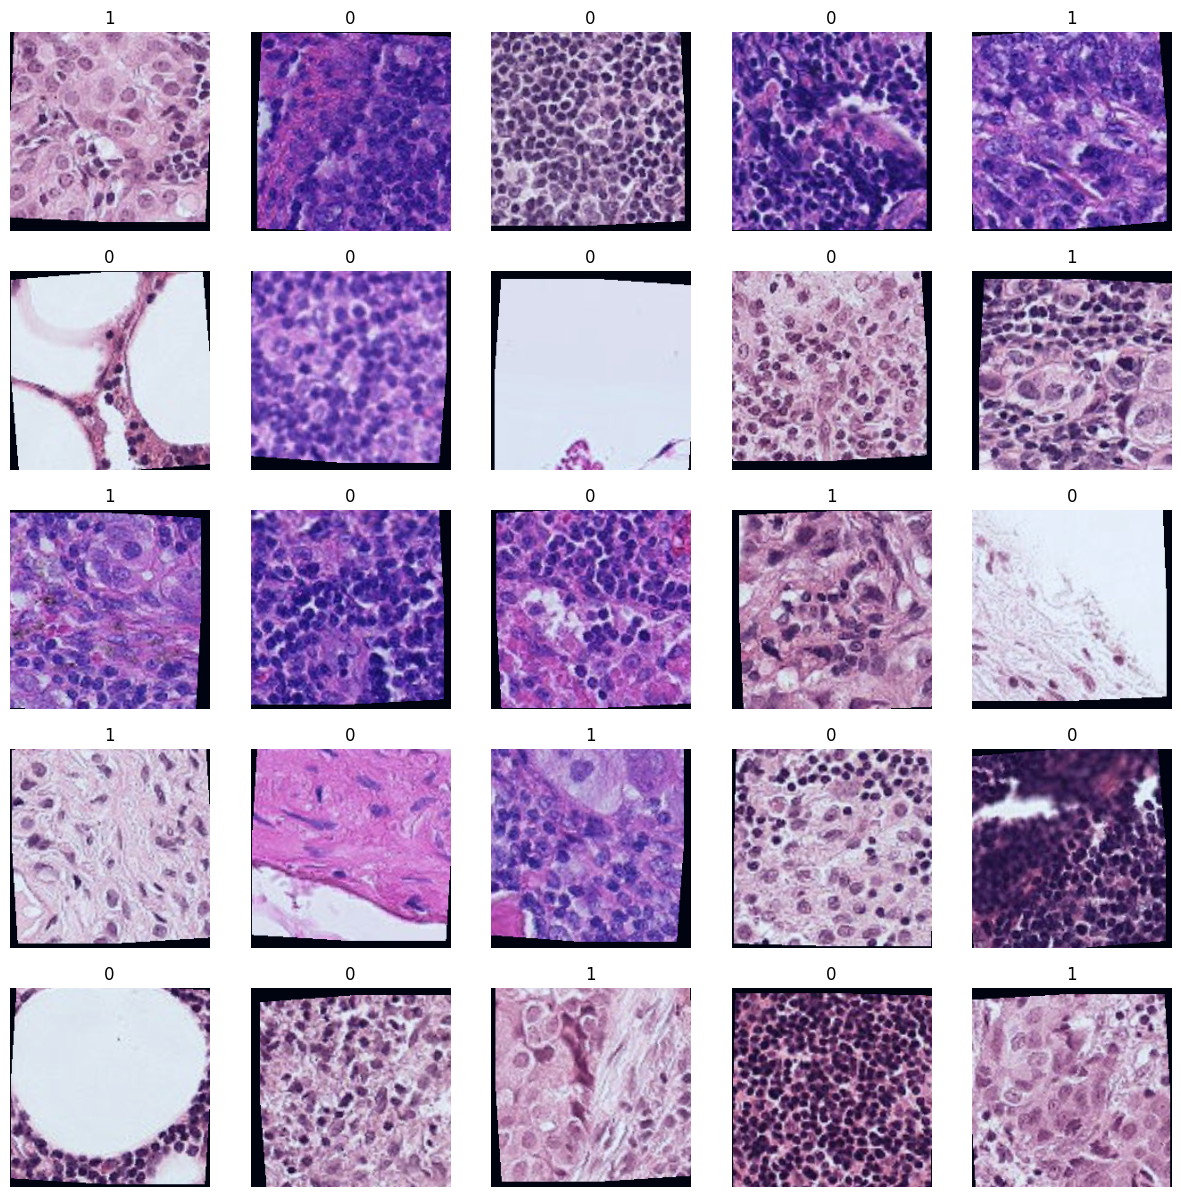

In [25]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = [0,1]

plot_images(images, labels, classes)

Base on the EDA, I will build a model that input the image and output the label, which is 0 or 1

Model Architecture :
Using ResNet50. I use CNN is because the dataset is an image dataset.

In [14]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [15]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample

    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)
        return x

In [16]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [17]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [19]:
from collections import namedtuple
ResNetConfig = namedtuple('ResNetConfig',['block', 'n_blocks', 'channels'])

In [20]:
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

In [21]:
m_trained = models.resnet50(pretrained=True)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
in_dim = m_trained.fc.in_features
out_dim = 2
fc = nn.Linear(in_dim, out_dim)

In [23]:
m_trained.fc = fc

In [24]:
model = ResNet(resnet50_config, out_dim)
model.load_state_dict(m_trained.state_dict())

<All keys matched successfully>

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,512,130 trainable parameters


In [47]:
Start_LR = 1e-7
optimizer = optim.Adam(model.parameters(), lr=Start_LR)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# code for cleaning the memory during training
# with torch.no_grad():
#     torch.mps.empty_cache()

In [49]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler

In [50]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [51]:

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r
                for base_lr in self.base_lrs ]
    
class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)
    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)
        return inputs, labels
    def get_batch(self):
        return next(self)

In [52]:
end_lr = 10
num_iter=100
lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, end_lr, num_iter)

Stopping early, the loss has diverged


In [53]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end=5):
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start: -skip_end]
    
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both','x')
    plt.show()

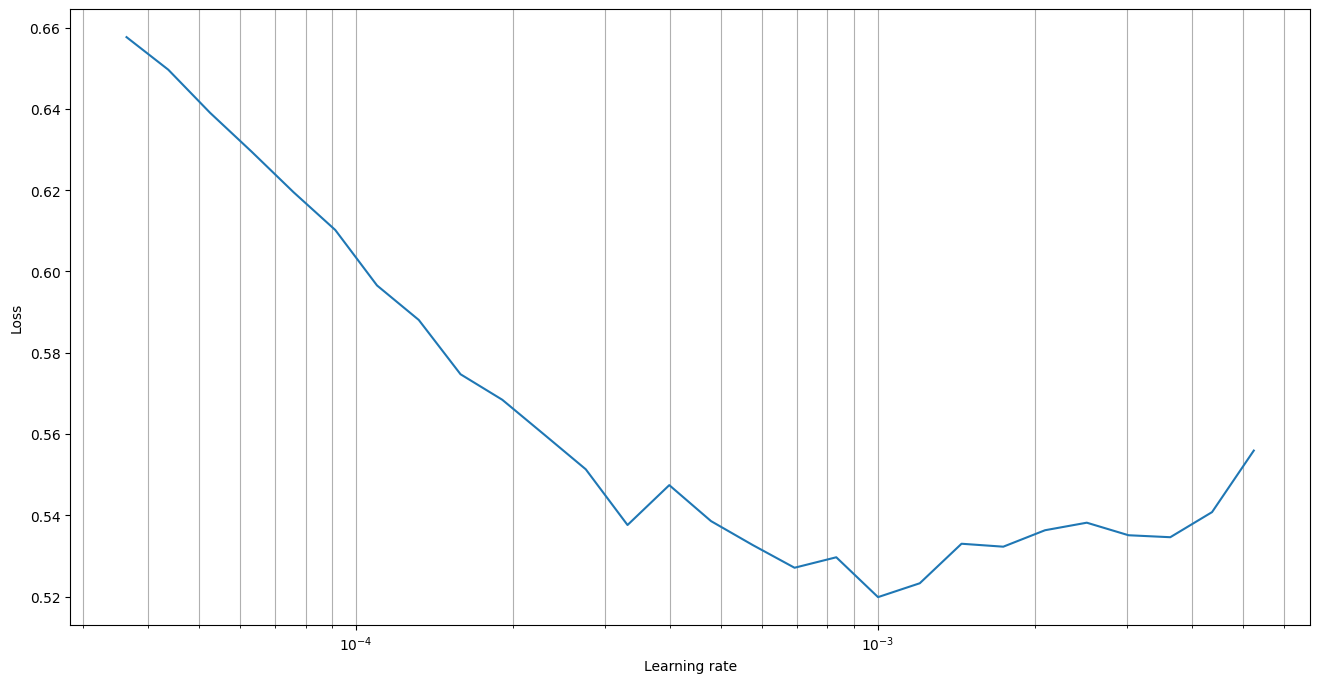

In [54]:
plot_lr_finder(lrs, losses, skip_start=30, skip_end=30)

We can see 1e-3 gives the lowest loss there, so we pick it.

In [55]:
FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

In [56]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [57]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [58]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        #acc_1, acc_5 = calculate_topk_accuracy(y_pred, y, k=1)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        # epoch_acc_1 += acc_1.item()
        # epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss

In [59]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            #acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            #epoch_acc_1 += acc_1.item()
            #epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss

In [60]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [62]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tValid Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 8m 38s
	Train Loss: 0.182
	Valid Loss: 0.112
Epoch: 02 | Epoch Time: 8m 37s
	Train Loss: 0.142
	Valid Loss: 0.134
Epoch: 03 | Epoch Time: 8m 37s
	Train Loss: 0.134
	Valid Loss: 0.132
Epoch: 04 | Epoch Time: 8m 37s
	Train Loss: 0.117
	Valid Loss: 0.093
Epoch: 05 | Epoch Time: 8m 37s
	Train Loss: 0.098
	Valid Loss: 0.091
Epoch: 06 | Epoch Time: 8m 38s
	Train Loss: 0.082
	Valid Loss: 0.076
Epoch: 07 | Epoch Time: 8m 39s
	Train Loss: 0.066
	Valid Loss: 0.058
Epoch: 08 | Epoch Time: 8m 38s
	Train Loss: 0.050
	Valid Loss: 0.059
Epoch: 09 | Epoch Time: 8m 38s
	Train Loss: 0.039
	Valid Loss: 0.049
Epoch: 10 | Epoch Time: 8m 38s
	Train Loss: 0.032
	Valid Loss: 0.049


In [65]:
model.load_state_dict(torch.load('tut5-model.pt'))

<All keys matched successfully>

In [29]:
def acc_validation(model, iterator, criterion, device):
    
    loss_valid, acc = 0, 0
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)
            
            bz = y_pred.shape[0]
            loss = criterion(y_pred, y)
            out = torch.argmax(y_pred, dim=-1)
            loss_valid += loss.item()
            acc += (out == y).sum().item()/bz



            # if(acc!=1.0):
            #     print("batch_size: ",bz)
            #     print("acc: ",(out == y).sum().item())
            #     break

    loss_valid /= len(iterator)
    # print("acc: ",acc)
    # print("len(iterator): ",len(iterator))
    acc /= len(iterator)
        
    return loss_valid, acc

In [26]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)
device

device(type='mps')

In [27]:
model.load_state_dict(torch.load('tut5-model.pt', map_location=torch.device('mps')))

<All keys matched successfully>

Results and Analysis

In [44]:
valid_loss, acc = acc_validation(model, valid_iterator, criterion, device)

print(f'Valid Loss: {valid_loss:.3f} | Acc @1: {acc*100:6.2f}%')

Valid Loss: 0.035 | Acc @1:  98.90%


We can see the accuracy is around 98% in validation set, which is great.

Results and Analysis

In [75]:
def predict(model, iterator):
    model.eval()

    images = []
    ys = []
    y_preds = []

    with torch.no_grad():

        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            
            y_prob = F.softmax(y_pred, dim= -1)

            images.append(x.cpu())
            ys.append(y.cpu())
            y_preds.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    ys = torch.cat(ys, dim = 0)
    y_preds = torch.cat(y_preds, dim=0)

    return images, ys, y_preds

In [79]:
images, y, y_preds = predict(model, valid_iterator)

In [193]:
y_pred = torch.argmax(y_preds, dim=-1)

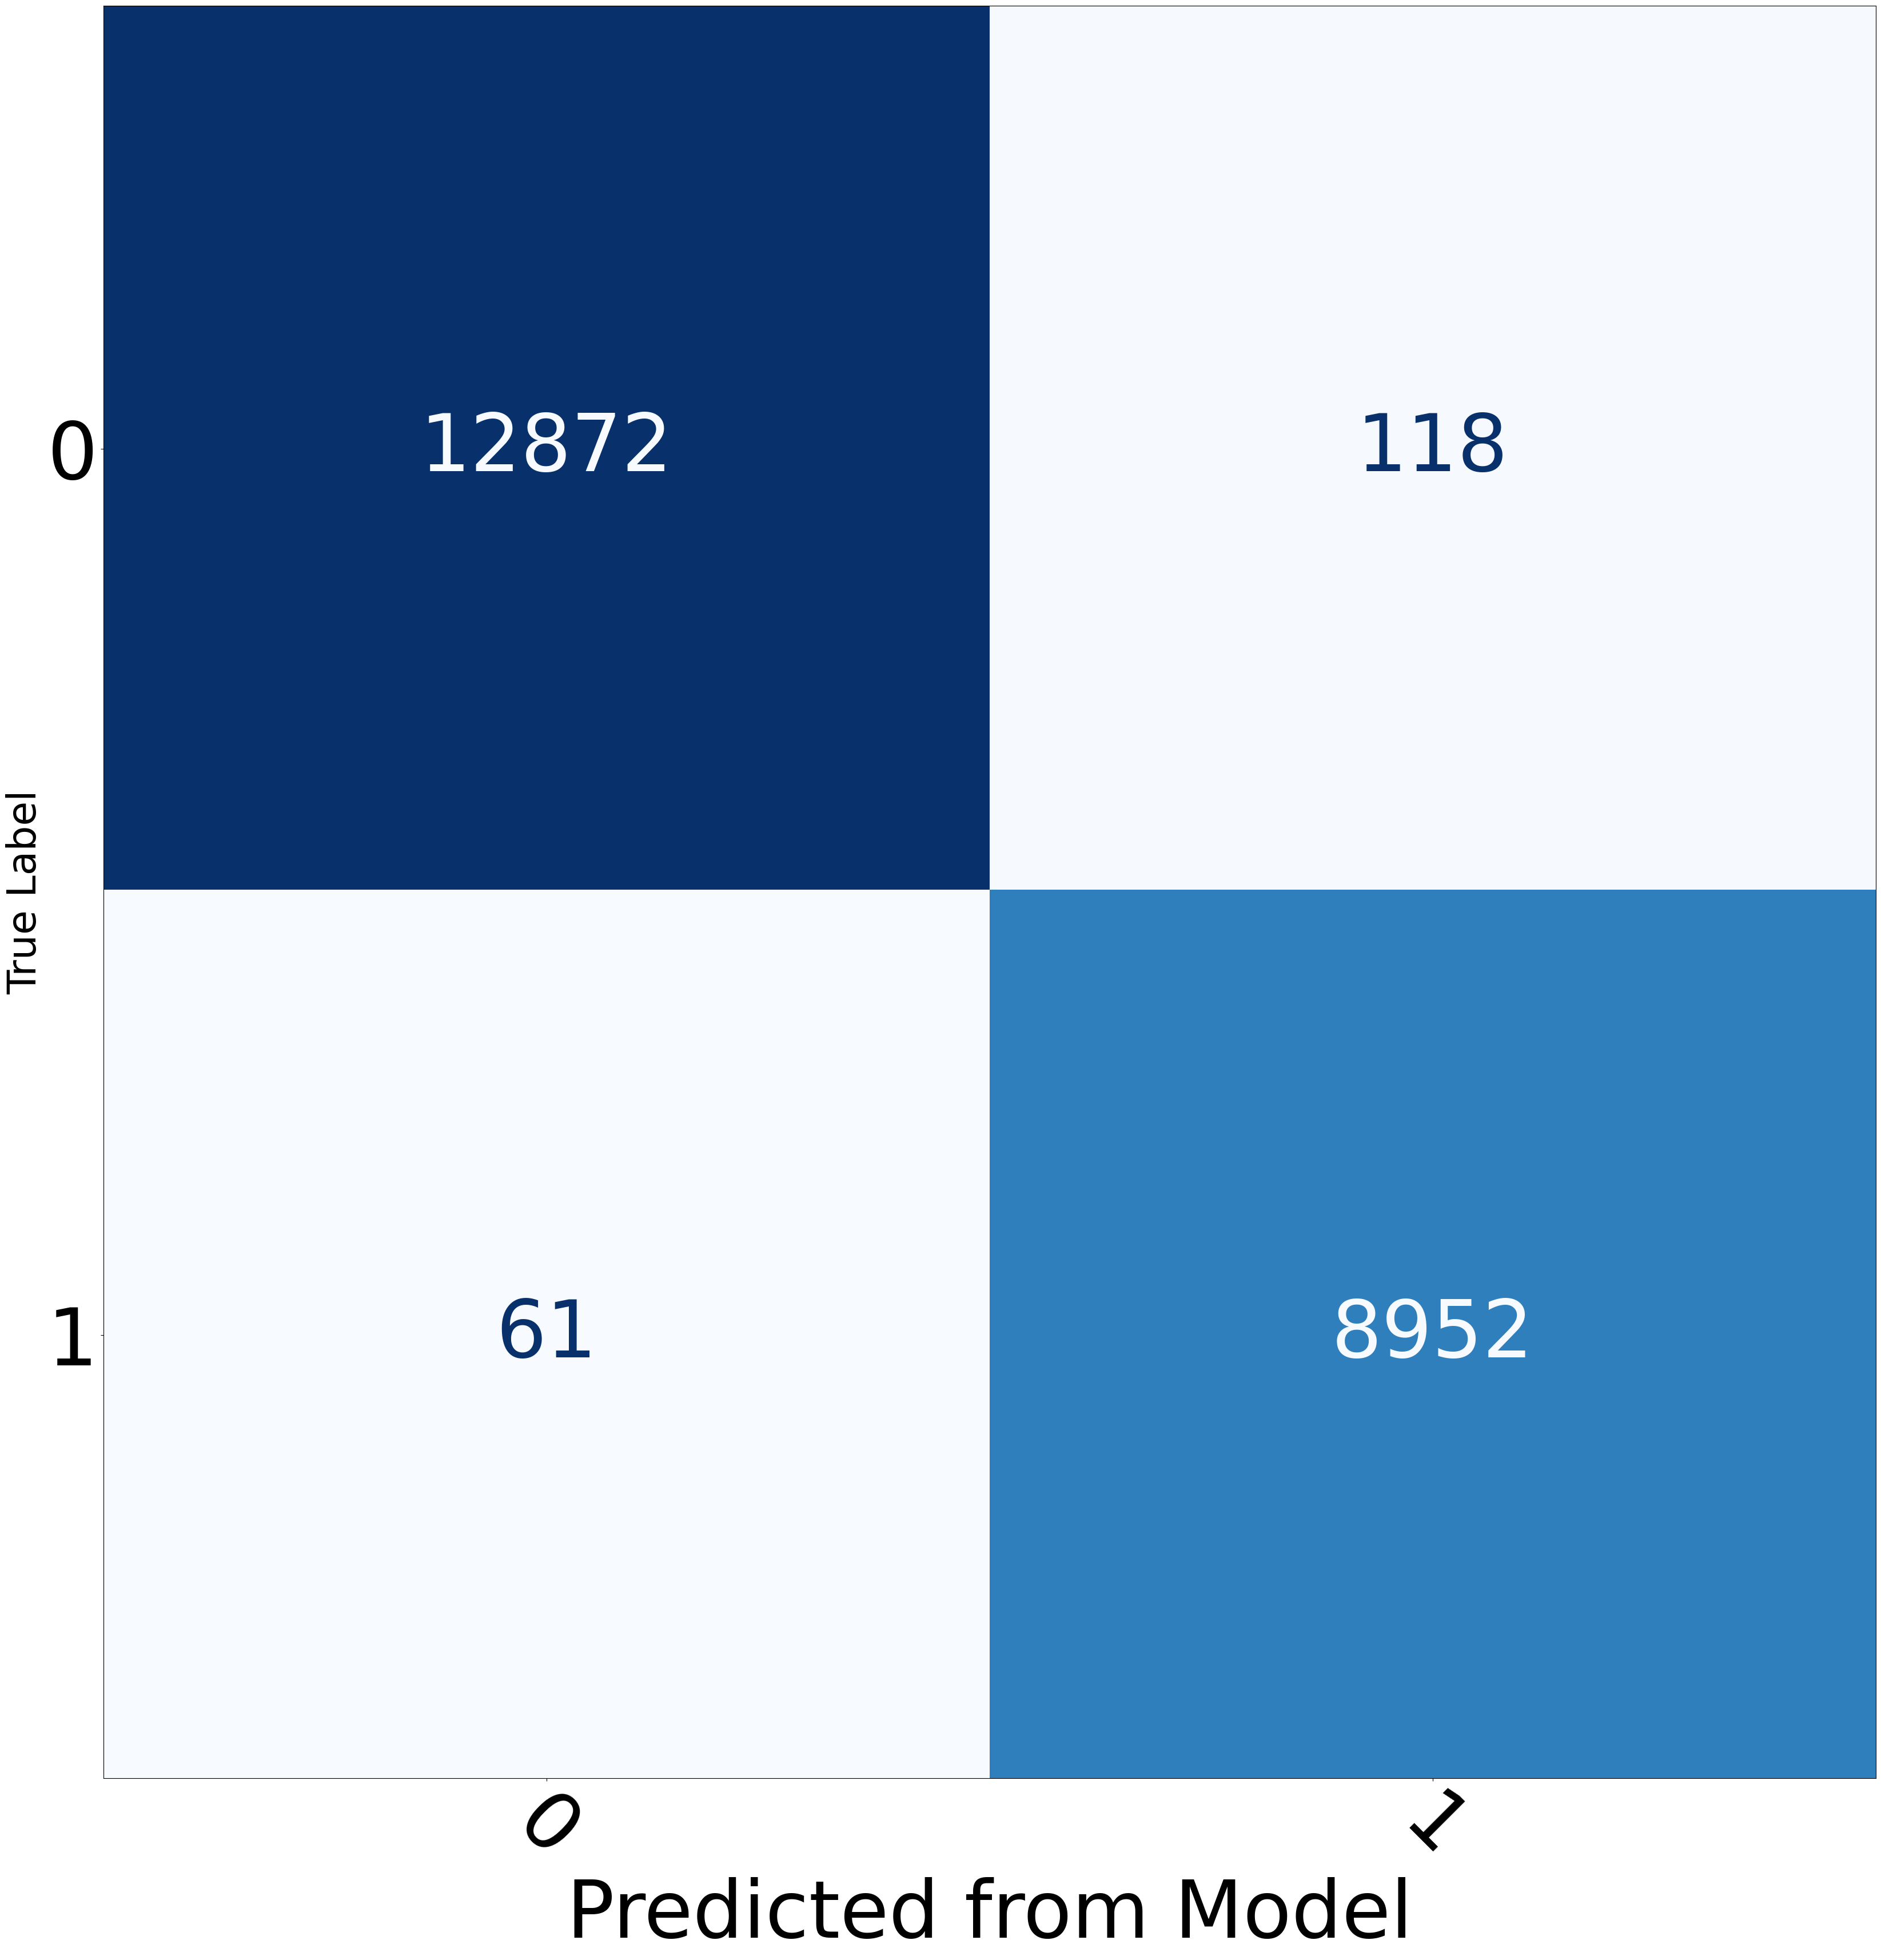

In [107]:
fig = plt.figure(figsize = (50, 50));
ax = fig.add_subplot(1, 1, 1);
cm = confusion_matrix(y, y_pred)
cm = ConfusionMatrixDisplay(cm, display_labels = [0, 1])
cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
fig.delaxes(fig.axes[1])
plt.xticks(rotation = -45)
plt.xlabel('Predicted from Model', fontsize=100)
plt.ylabel('True Label', fontsize=50)
ax.tick_params(axis='both', labelsize=100)

# Change font size for matrix values
for text in ax.texts:
    text.set_size(100)
plt.show()


For problem like cancer detection by image, we can see at least the number of false negative is lower than the false positive. That is great.

In [191]:
images, y, y_preds = predict(model, valid_iterator)

In [197]:
y_pred = torch.argmax(y_preds, dim=-1)

In [198]:
y_pred

tensor([1, 1, 1,  ..., 1, 1, 1])

In [40]:
class ImageDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        if(csv_path != None):
            self.labels_df = pd.read_csv(csv_path) if csv_path else None
            self.sz =  len(self.labels_df)
        else:
            self.labels_df = None
            self.sz = len(os.listdir(img_dir))
        self.file_names = os.listdir(img_dir)
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return self.sz

    def __getitem__(self, idx):
        #filename is the id in the cvs
        #This case must be a test case
        img_path, label = None, None

        if self.labels_df == None:
            #Since it is a kaggle testset, it doesn't have label.
            #As a result, I will just return the file name
            label = self.file_names[idx]
            img_path = os.path.join(self.img_dir,self.file_names[idx])
            #print("Debug: ", img_path)
        else:
            filename = self.labels_df.iloc[idx]['id']+".tif"
            label = self.labels_df.iloc[idx]['label']

            img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label[:-4]

In [41]:
test_data = ImageDataset(csv_path = None,
                              img_dir='data/histopathologic-cancer-detection/test',
                              transform=test_transforms)               

In [176]:
s = 'data/histopathologic-cancer-detection/test'
s1 = os.listdir(s)[0]
s1

'fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif'

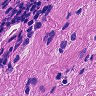

In [177]:
img_path = os.path.join(s, s1)
image = Image.open(img_path)
image

In [42]:
test_data = ImageDataset(csv_path = None,
                              img_dir='data/histopathologic-cancer-detection/test',
                              transform=test_transforms)
print(f'Number of testing examples: {len(test_data)}')               

Number of testing examples: 57458


In [179]:
test_data[0][1]


'fd0a060ef9c30c9a83f6b4bfb568db74b099154d'

In [180]:
s2 = "fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif"
s2[:-4]

'fd0a060ef9c30c9a83f6b4bfb568db74b099154d'

In [43]:
test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [88]:
def predict_test(model, iterator):
    model.eval()

    df = pd.DataFrame(columns=["id","label"])
    ids = []
    y_preds = None
    with torch.no_grad():
        i = 0
        for (x,  id) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            
            y_prob = F.softmax(y_pred, dim= -1)
            y_prob = torch.argmax(y_prob, dim=-1).cpu().numpy()

            ids += id

            if(i == 0):
                y_preds = y_prob
                i+=1
            else:
                y_preds = np.concatenate((y_preds, y_prob))
            #print(len(ids),y_preds.shape)
            
    df = pd.DataFrame({
    'id': ids,
    'label': y_preds
    })
    return df

In [89]:
df = predict_test(model, test_iterator)

Conclusion:
We can see the model preformace is great eventhough it is a medical problem like cancer detection.

In [90]:
df

,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,0
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,0
2,19709bec800f372d0b1d085da6933dd3ef108846,0
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0
...,...,...
57453,2581931c6ef068f105a872f2c5500275fc678242,0
57454,11b250a664d09ab59fd2afbdb2f8d786763b185d,1
57455,18a6030935ec1ef1ce486ec51bc95abb4008fbf1,0
57456,f541404e501e23a0188c852eb37eac94053cfdc0,0


In [92]:
df.to_csv("submit.csv", index=False)

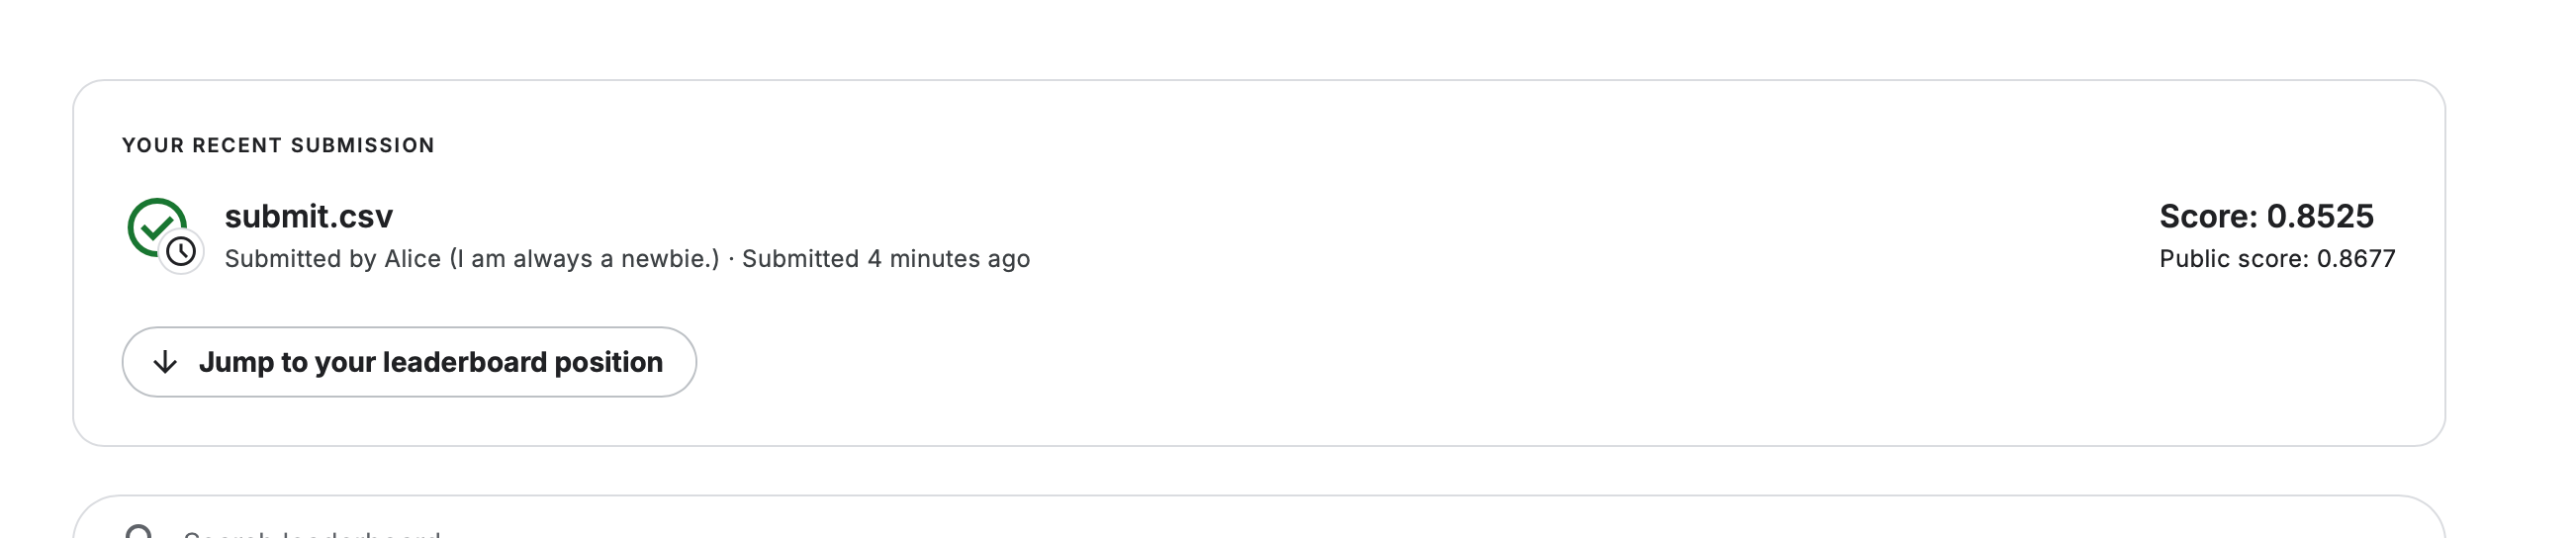

Looking my validation accuracy was about 98%, but the test set only has 85% accuracy. I can tell there is a lot of problem on my model and code. It is possible there is a data leak. Improvement should be using AdamW rather than Adam.